In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.utils as utils
from astropy.table import Table, Column
import json
from scipy.optimize import curve_fit
import pprint

In [2]:
# Establish where the LSST simulations data is coming from, and where output data will go
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [3]:
# Establish points of evaluation, how to evaluate (slice) them, and any constraints
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
# slicer = slicers.UserPointsSlicer(ra,dec)
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,size=10),np.random.uniform(-60,-30,size=10))
sql = ''
# Run the metric, slicer, and constraint together as a "bundle"
bundle = metricBundles.MetricBundle(metric,slicer,sql)
# Group the previous bundle with the data from the LSST simulations
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
%time bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 35.1 s, sys: 2.41 s, total: 37.5 s
Wall time: 55 s


In [4]:
def survey_setup(bundle):
    opsimlist = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for key in ['fieldRA', 'fieldDec', 
                                                                  'expMJD', 'filter', 'fiveSigmaDepth']}
        opsim = Table(bdict)
        opsim['expMJD'] = opsim['expMJD'] - opsim['expMJD'].min()
        opsim.sort(['expMJD'])
        opsim = opsim['fieldRA', 'fieldDec', 'expMJD','filter','fiveSigmaDepth']
    
        # Only do the following if you need to narrow simulation filters to those matching your lightcurve data
        opsim = opsim[opsim['filter'] != 'u']
        opsim = opsim[opsim['filter'] != 'y']
        opsimlist.append(opsim)
    return opsimlist

In [5]:
def tde_raw(jsonfile):
    # Open and load json file with TDE values
    tde_data = open(jsonfile)
    tde = json.load(tde_data)
    # Set up dictionary for json data
    data = {'mjd': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
    # Use for loop to call to values within the json file
    for entry in tde['PS1-10jh']['photometry']:
        # Ignore instances in which 'band' and 'magnitude' have no data
        if 'band' in entry and 'magnitude' in entry:
            data['mjd'].append(float(entry['time']))
            data['filter'].append(entry['band'])
            data['mag'].append(float(entry['magnitude']))
            # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
            if 'upperlimit' in entry:
                data['upperlimit'].append(entry['upperlimit'])
            else:
                data['upperlimit'].append(False)
            # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
            if 'e_magnitude' in entry:
                data['magerror'].append(float(entry['e_magnitude']))
            else:
                data['magerror'].append(99)
    # Table the now-full dictionary of TDE data
    tde_table = Table(data)
    # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
    # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
    tde_table = tde_table[tde_table['magerror'] < 0.3]
    tde_table = tde_table[tde_table['upperlimit'] == False]
    tde_table['mjd'] = tde_table['mjd'] - tde_table['mjd'].min()
    tde_table = tde_table[tde_table['mjd'] < 170]
    tde_table = tde_table[tde_table['filter'] != 'NUV']
    tde_table = tde_table[tde_table['filter'] != 'F225W']
    return tde_table

In [6]:
def find_peak(tde_table):
    peak = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        peakmag = np.amin(tde_table['mag'][filter_match])
        peakmag_row = np.argmin(tde_table['mag'][filter_match])
        peakday = tde_table['mjd'][filter_match][peakmag_row]
        peak[f] = {'peakday': peakday, 'peakmag': peakmag}
    return peak

In [7]:
def shift_peak(tde_table, templatepeak, outputmag, outputtime):
    """
    Shifts peak magnitude and time of peak of a template lightcurve.
    """
    output_tde_table = tde_table.copy()
    output_tde_table['mag'] -= templatepeak['r']['peakmag'] - outputmag
    output_tde_table['mjd'] -= templatepeak['r']['peakday'] - outputtime
    return output_tde_table

In [8]:
def func(x, outputmag, outputtime):
    """
    Function that relates the resampled data to the overall interpolated lightcurve.
    """
    opsim, totalpeak = x
    survey = opsim.copy()
    survey['magnitude'] -= totalpeak['r']['peakmag'] - outputmag
    survey['expMJD'] -= totalpeak['r']['peakday'] - outputtime
    return survey

In [9]:
def interpolate_lc(tde_table, time_range):
    lc = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        lc[f] = np.interp(time_range, tde_table['mjd'][filter_match], tde_table['mag'][filter_match])
    return lc

In [10]:
def resample_lc(opsim, tde_table):
    time_range = opsim['expMJD']
    lc = interpolate_lc(tde_table, time_range)
    tde_lc = Table(lc)
    tde_lc['mjd'] = time_range
    tde_lc = tde_lc['mjd', 'g', 'r', 'i', 'z']
    return tde_lc

In [11]:
def update_opsim(opsim, tde_lc):    
    opsim['magnitude'] = 0.0
    for row in range(len(opsim)):
        f = opsim['filter'][row]
        opsim['magnitude'][row] = tde_lc[f][row]
    return opsim

In [12]:
def find_error(opsim):
    # Find error based off of 5sigDepth, and add it to the table with magnitudes
    snr = 5*(10**((-0.4)*(opsim['magnitude'] - opsim['fiveSigmaDepth'])))
    tde_err = 2.5/(snr*np.log(10))
    opsim['tde_err'] = tde_err
    opsim = opsim[opsim['tde_err'] < 0.3]
    return opsim

In [13]:
def plot_interpolated_lightcurve(opsim):
    fig, ax = plt.subplots(1, 1)
    ra = round(opsim['fieldRA'][0], 5)
    dec = round(opsim['fieldDec'][0], 5)
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(opsim['filter'] == f)
        ax.errorbar(opsim['expMJD'][filter_match], opsim['magnitude'][filter_match],
                    yerr = opsim['tde_err'][filter_match], color = colors[f], fmt = '*')
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    legend = ax.legend(handles,[f for f in ['g', 'r', 'i', 'z']])
    ax.set_ylim(plt.ylim()[::-1])
    ax.set_title('PS1-10jh resampled lightcurve, ra = %r, dec = %r, peakmag = %d, peaktime = %d'
                  % (ra, dec, testpeakmag, testpeakday))
    ax.set_xlabel('Day')
    ax.set_ylabel('Magnitude')

In [14]:
def poly(x, a, b, c, d, e, f, g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

In [15]:
def interpolate_lc_alltimes():
    time_range = np.arange(0, 120, 1)
    lc = interpolate_lc(tde_table, time_range)
    lc = Table(lc)
    lc['mjd'] = time_range
    tde_lc_all = Table()
    tde_lc_all.add_column(Column(name = 'mjd'))
    tde_lc_all.add_column(Column(name = 'filter'))
    tde_lc_all.add_column(Column(name = 'mag'))
    tde_lc_all = Table(names = ('mjd', 'filter', 'mag'), dtype = ('float', 'str', 'float'))
    for day in lc['mjd']:
        for f in ['g', 'r', 'i', 'z']:
            row = np.where(lc['mjd'] == day)
            tde_lc_all.add_row([day, f, lc[f][row]])
    return tde_lc_all

In [16]:
def curvefit_full_lightcurve(tde_lc_all):
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_lc_all['filter'] == f)
        popt, pcov = curve_fit(poly, tde_lc_all['mjd'][filter_match], tde_lc_all['mag'][filter_match])
        plt.figure()
        plt.plot(tde_lc_all['mjd'][filter_match], tde_lc_all['mag'][filter_match], 
                 color = colors[f], label = '%s raw lightcurve' % f)
        plt.plot(tde_lc_all['mjd'][filter_match], poly(tde_lc_all['mjd'][filter_match], *popt), 
                 'black', label = '%s curvefit lightcurve' % f)
        plt.ylim(plt.ylim()[::-1])
        plt.title('TDE \'Curvefit\' and TDE interpolated over all times')
        plt.xlabel('Day')
        plt.ylabel('Magnitude')
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [17]:
def poly2(x, a, b, c):
    return a*x**2 + b*x + c

In [18]:
def curvefit_resampled_plot_all(opsim, f, tde_lc_all, tde_table):
    filter_match3 = np.where(tde_lc_all['filter'] == f)
    time_range = np.arange(opsim['expMJD'].min(), opsim['expMJD'].max(), 1)
    popt, pcov = curve_fit(poly2, opsim['expMJD'], opsim['magnitude'])
    plt.figure()
    plt.errorbar(opsim['expMJD'], opsim['magnitude'], 
                 yerr = opsim['tde_err'], color = colors[f],
                 fmt = '*', label = '%s resampled lightcurve' % f)
    plt.plot(time_range, poly2(time_range, *popt), 
             'black', label = '%s curvefit resampled lightcurve' %f)
    plt.plot(tde_lc_all['mjd'][filter_match3], tde_lc_all['mag'][filter_match3], 
             color = colors[f], label = '%s raw lightcurve' % f)
    plt.ylim(plt.ylim()[::-1])
    plt.title('Original, resample, and curvefit in %s at ra=%f and dec=%f, peakmag=%d and peaktime=%d'
              % (f, ra, dec, testpeakmag, testpeakday))
    plt.xlabel('Day')
    plt.ylabel('Magnitude')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [96]:
def find_peak_mag_diff(opsim, f, tde_table):
    filter_match4 = np.where(tde_table['filter'] == f)
    time_range = np.arange(opsim['expMJD'].min(), opsim['expMJD'].max(), 1)
    popt, pcov = curve_fit(poly2, opsim['expMJD'], opsim['magnitude'])
    original_peak_mag = tde_table['mag'][filter_match4].min()
    curvefit_peak_mag = poly2(time_range, *popt).min()
    peak_diff_mag = curvefit_peak_mag - original_peak_mag
    return peak_diff_mag

In [97]:
def find_peak_day_diff(opsim, f, tde_table):
    filter_match4 = np.where(tde_table['filter'] == f)
    time_range = np.arange(opsim['expMJD'].min(), opsim['expMJD'].max(), 1)
    popt, pcov = curve_fit(poly2, opsim['expMJD'], opsim['magnitude'])
    original_peak_day = tde_table['mag'][filter_match4].argmin()
    curvefit_peak_day = poly2(time_range, *popt).argmin()
    peak_diff_day = curvefit_peak_day - original_peak_day
    return peak_diff_day

In [98]:
def make_peak_diff_table():
    peak_diff_mag = find_peak_mag_diff(opsim, f, tde_table)
    peak_diff_day = find_peak_day_diff(opsim, f, tde_table)
    peak_diff_dict['ra'].append(ra)
    peak_diff_dict['dec'].append(dec)
    peak_diff_dict['peak_diff_mag'].append(peak_diff_mag)
    peak_diff_dict['peak_diff_day'].append(peak_diff_day)
    peak_diff_table = Table(peak_diff_dict)
    return peak_diff_table

enough = 28
not enough = 132
   ra     dec     peak_diff_mag   peak_diff_day
------- -------- ---------------- -------------
1.56379 -0.91558  -0.128145114558            45
1.56379 -0.91558  -0.128145114558            45
1.56379 -0.91558  -0.128145114558            45
1.56379 -0.91558  -0.128145114558            45
 4.6319 -0.61857 -0.0809782284673            10
 4.6319 -0.61857 -0.0809782284673            10
 4.6319 -0.61857 -0.0809782284673            10
 4.6319 -0.61857 -0.0809782284673            10
2.09671 -0.80581 -0.0819383105834            44
2.09671 -0.80581 -0.0819383105834            44
    ...      ...              ...           ...
0.09283 -0.64901  -0.392216011909            43
0.09283 -0.64901  -0.392216011909            43
0.09283 -0.64901  -0.392216011909            43
0.10216 -0.74508   0.158081017797            46
0.10216 -0.74508  -0.351918982203            46
0.10216 -0.74508   0.158081017797            46
0.10216 -0.74508  -0.351918982203            46
0.10216 -0.

(array([  4.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,  20.]),
 array([ 10. ,  13.6,  17.2,  20.8,  24.4,  28. ,  31.6,  35.2,  38.8,
         42.4,  46. ]),
 <a list of 10 Patch objects>)

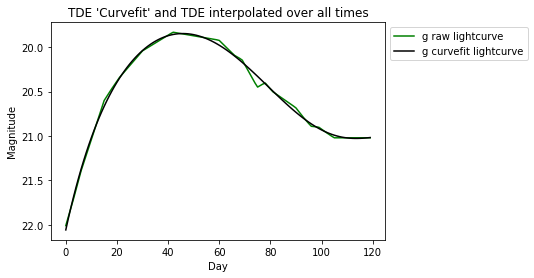

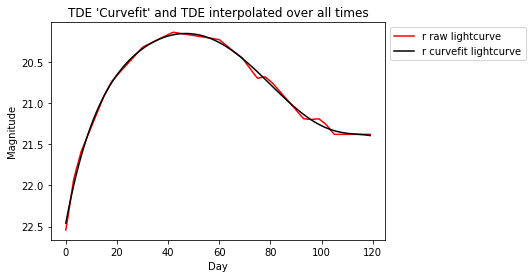

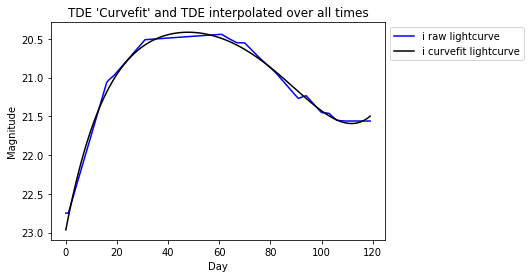

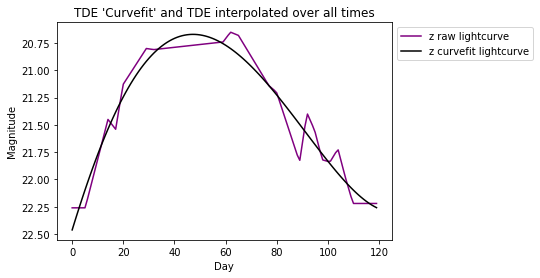

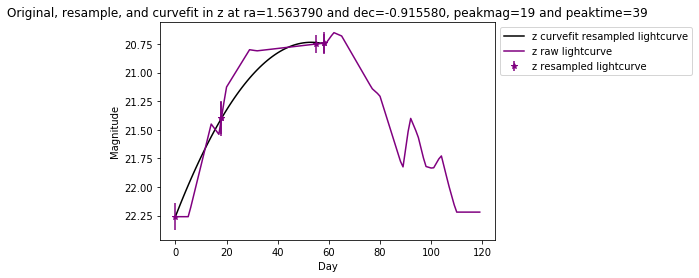

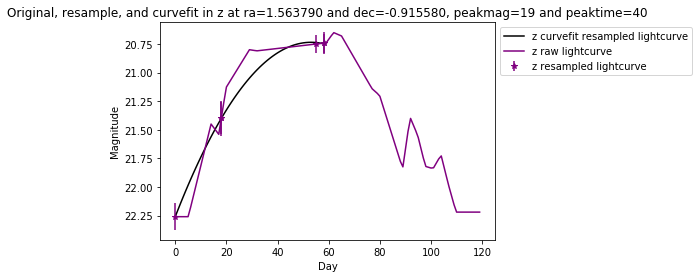

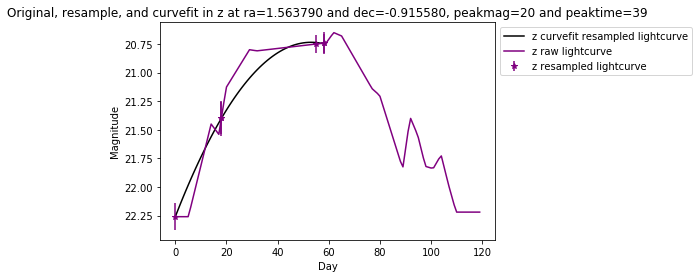

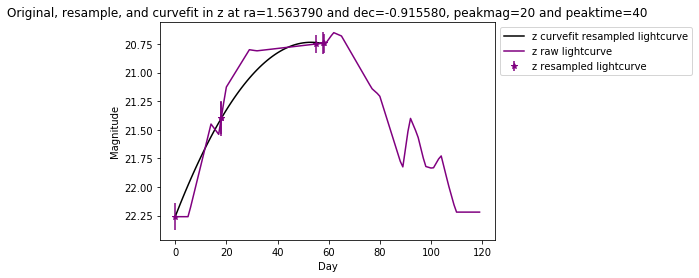

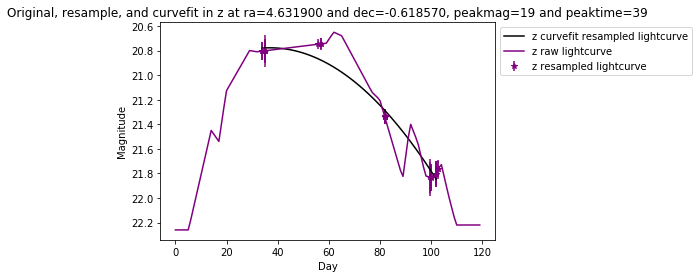

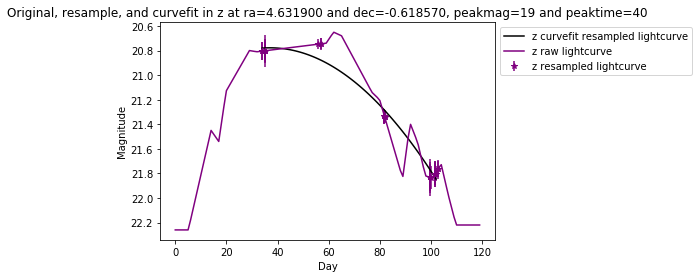

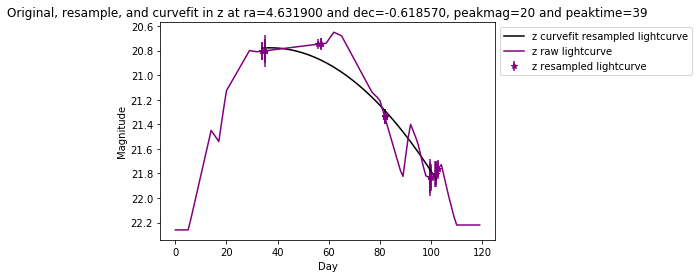

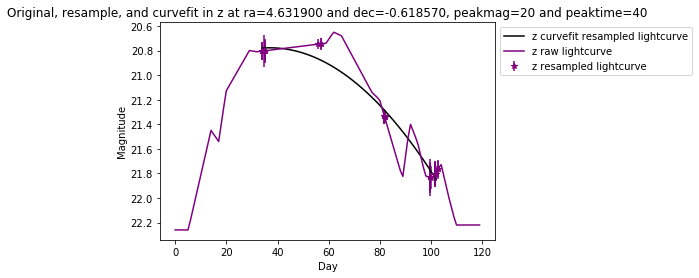

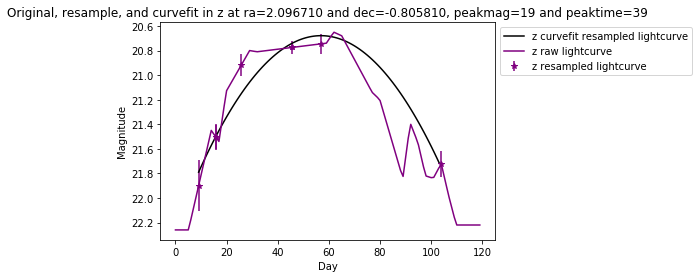

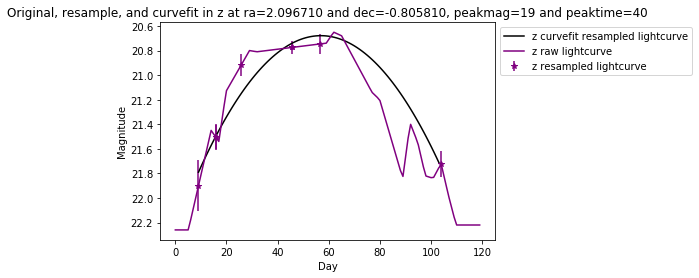

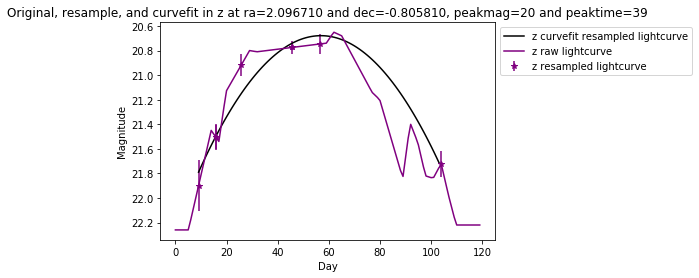

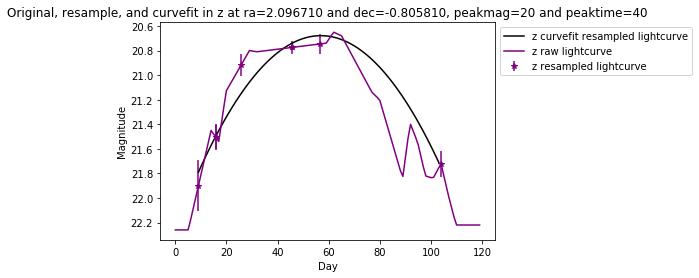

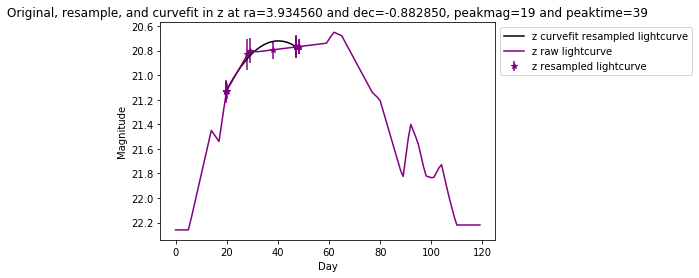

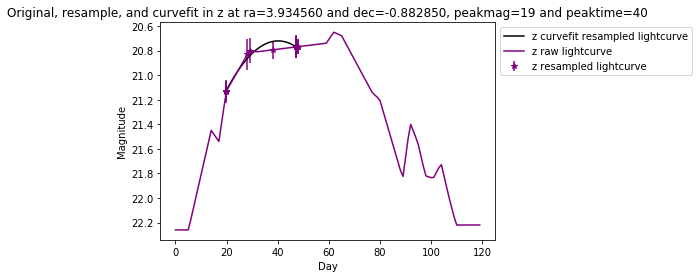

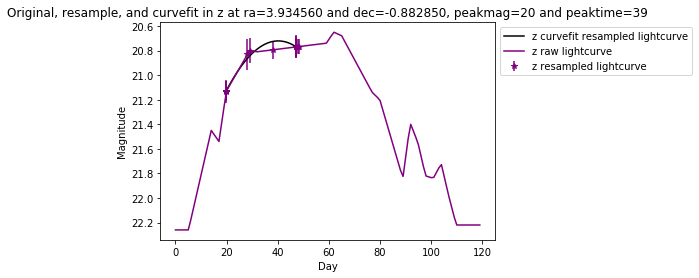

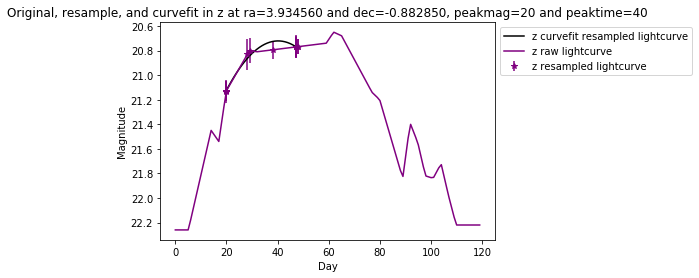

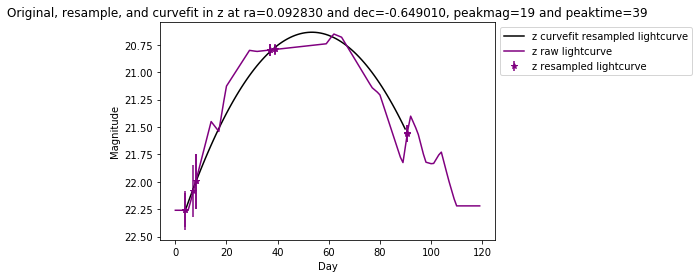

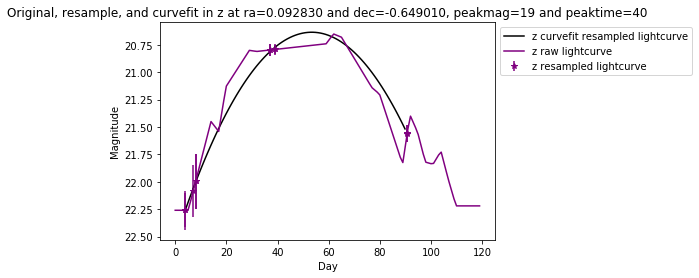

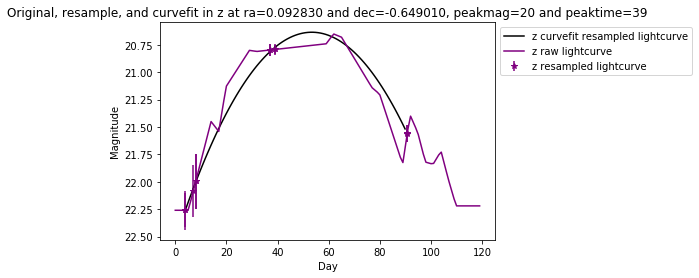

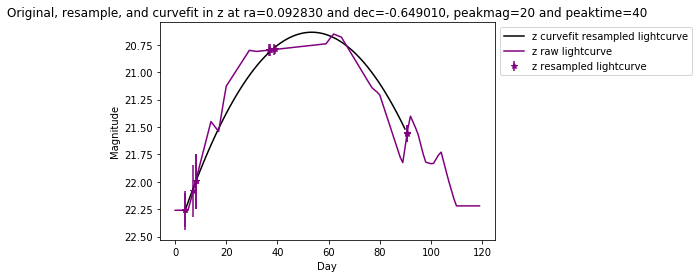

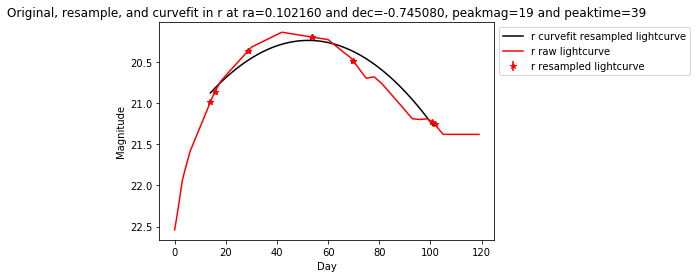

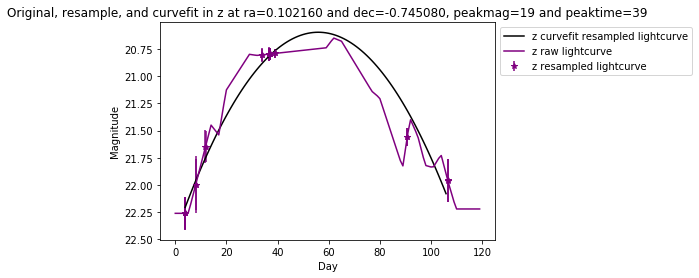

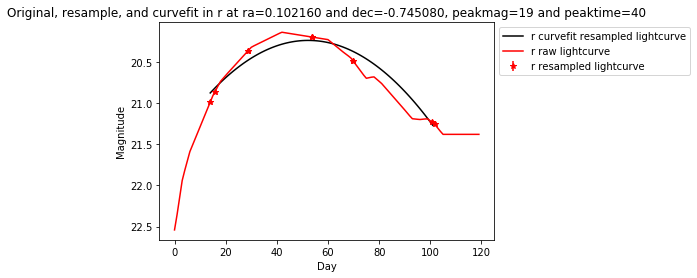

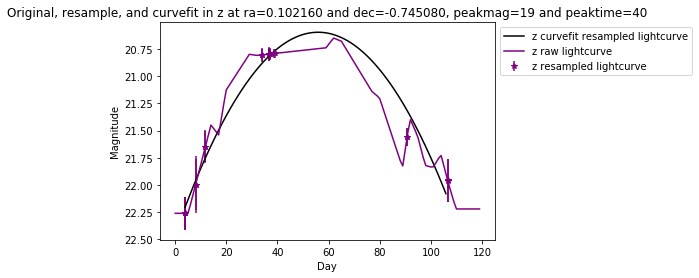

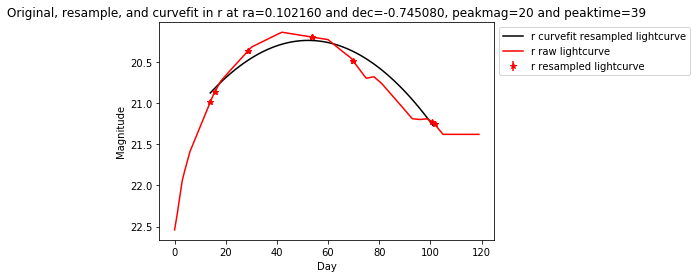

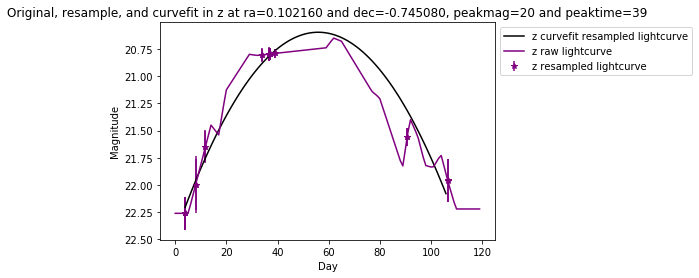

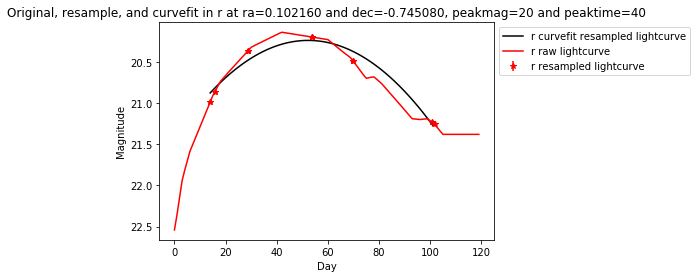

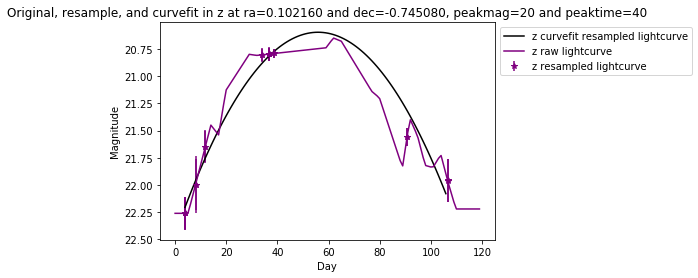

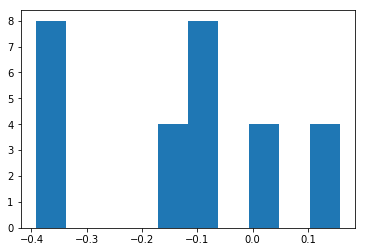

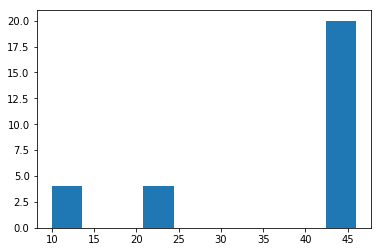

In [102]:
# Setup input variables needed, and run in order of function introduction
lowestpeakmag = np.arange(19, 21, 1)
lowestpeaktime = np.arange(39, 41, 1)
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
opsimlist = survey_setup(bundle)
tde_table = tde_raw('PS1-10jh.json')
inputpeak = find_peak(tde_table)
tde_lc_all = interpolate_lc_alltimes()
curvefit_full_lightcurve(tde_lc_all)
enough = 0.
not_enough = 0.
peak_diff_dict = {'ra': [], 'dec': [], 'peak_diff_mag': [], 'peak_diff_day': []}

for coord in range(len(bundle.metricValues)):
    adjustedopsim = np.copy(opsimlist)
    opsim = adjustedopsim[coord]
    for testpeakmag in lowestpeakmag:
        for testpeakday in lowestpeaktime:
            adjusted_tde = shift_peak(tde_table, inputpeak, testpeakmag, testpeakday)
            opsim = opsim[opsim['expMJD'] > adjusted_tde['mjd'].min()]
            opsim = opsim[opsim['expMJD'] < adjusted_tde['mjd'].max()]
            tde_lc = resample_lc(opsim, tde_table)
            opsim = update_opsim(opsim, tde_lc)
            opsim = find_error(opsim)
            survey = opsim.copy()
            survey = survey[survey['expMJD'] <= 60]
            for f in ['g', 'r', 'i', 'z']:
                filter_match = np.where(survey['filter'] == f)
                survey2 = survey[filter_match]
                filter_match2 = np.where(opsim['filter'] == f)
                opsim_fmatch = opsim[filter_match2]
                if len(np.unique(np.round(survey2['expMJD']))) >= 4:
                    ra = round(opsim['fieldRA'][0], 5)
                    dec = round(opsim['fieldDec'][0], 5)
                    plot = curvefit_resampled_plot_all(opsim_fmatch, f, tde_lc_all, tde_table)
                    peak_diff_table = make_peak_diff_table()
                    enough += 1
                else:
                    not_enough += 1

print('enough = %d' %(enough))
print('not enough = %d' %(not_enough))
peak_diff_table = peak_diff_table['ra', 'dec', 'peak_diff_mag', 'peak_diff_day']
print peak_diff_table

plt.figure()
plt.hist(peak_diff_table['peak_diff_mag'])
plt.figure()
plt.hist(peak_diff_table['peak_diff_day'])